In [1]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add to utils.py: BER vs SNR, improve complex signal handling
- Add timing synchronization
- Add multipath effects to channel & equalizer
- Time offset
- Framing? Detect start of frame


Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add to utils.py: BER vs SNR, improve complex signal handling\n- Add timing synchronization\n- Add multipath effects to channel & equalizer\n- Time offset\n- Framing? Detect start of frame\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [2]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import sys
sys.path.insert(0, '..')
import importlib
import utils
importlib.reload(utils)
from utils import *


# Constants
SPS = int(2)
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1
SNR_DB = 20


/home/cdelong/sdr/temp/sdr_notebooks/notebooks/../utils/visualization.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


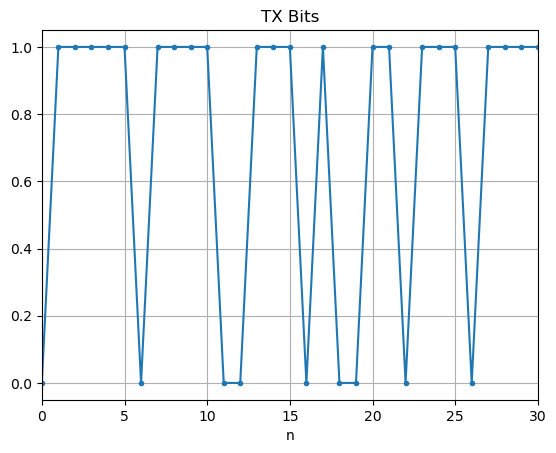

In [3]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

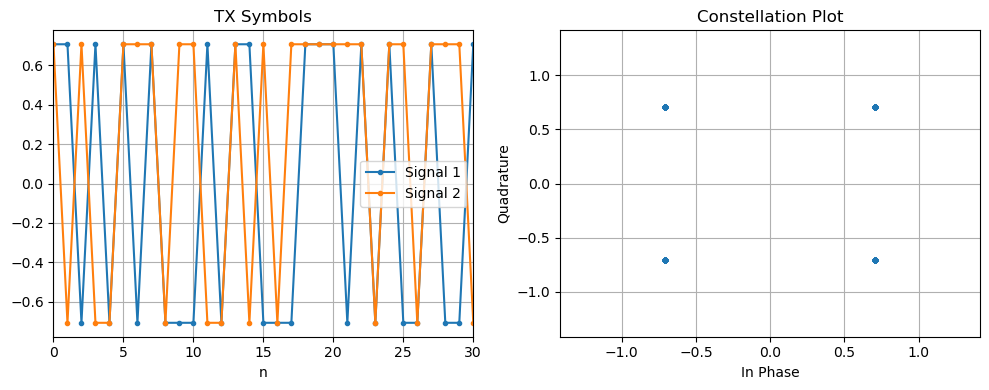

In [4]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
sym_tx = diff_encode_psk_symbols(modulate_qpsk(bits_tx))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30], ax=axs[0])
plot_constellation(sym_tx, ax=axs[1])
plt.tight_layout()
plt.show()

/home/cdelong/sdr/temp/sdr_notebooks/notebooks/../utils/visualization.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


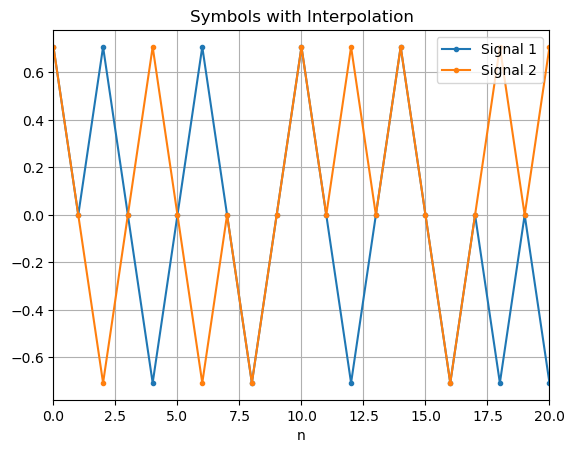

In [5]:
### Pulse filtering ###

# Upsample by factor of SPS
sym_upsamp = upsample(sym_tx, SPS)

plot_signal(sym_upsamp.real, sym_upsamp.imag, title='Symbols with Interpolation', xlim=[0, 10*SPS])

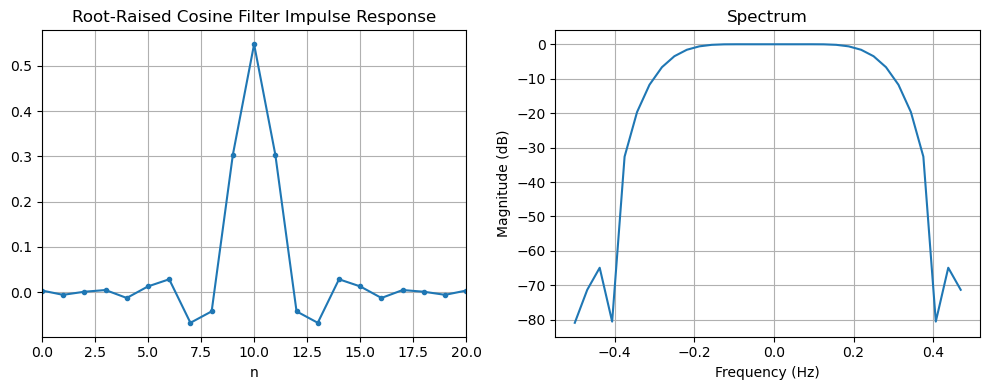

In [6]:
h_rrc = rrc_coef(Ts=SPS, n_taps=N_RRC_TAPS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response', ax=axs[0])
plot_spectrum(h_rrc, ax=axs[1])
plt.tight_layout()
plt.show()

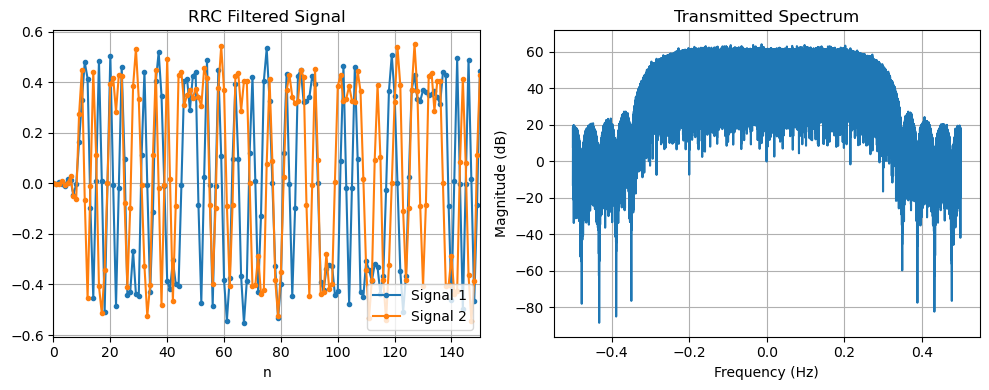

In [7]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_upsamp, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_tx, title="Transmitted Spectrum", ax=axs[1])
plt.tight_layout()
plt.show()

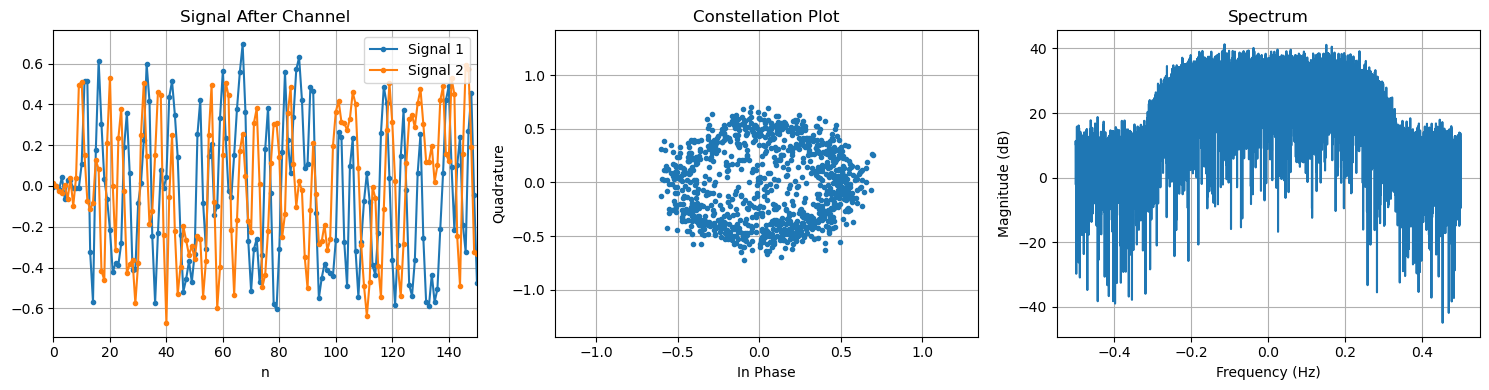

In [8]:
### Channel ###

# Apply CFO
# testing/realistic: 1-5%, aggressive: 10%
sig_chan = apply_cfo(sig_tx, 0.01)

# Apply CPO
sig_chan = apply_cpo(sig_chan)

# Apply STO
mu = 0.3
sig_chan = apply_sto(sig_chan, mu)

# AWGN
sig_rx = apply_awgn(sig_chan, SNR_DB)

# Visualize signal after channel
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150], ax=axs[0])
plot_constellation(sig_rx, ax=axs[1])
plot_spectrum(sig_rx, n_samples=2**13, ax=axs[2])
plt.tight_layout()
plt.show()


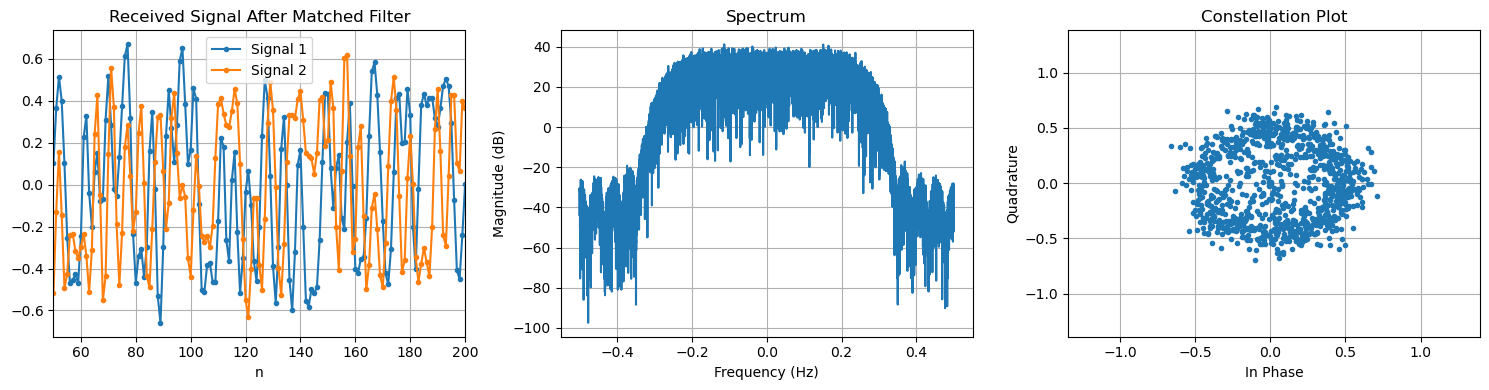

In [9]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter', ax=axs[0])
plot_spectrum(sig_matched, n_samples=2**13, ax=axs[1])
plot_constellation(sig_matched, n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()

# Remove extra samples from convolutions
sig_matched = sig_matched[N_RRC_TAPS-1 : (N_RRC_TAPS-1) * -1]


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


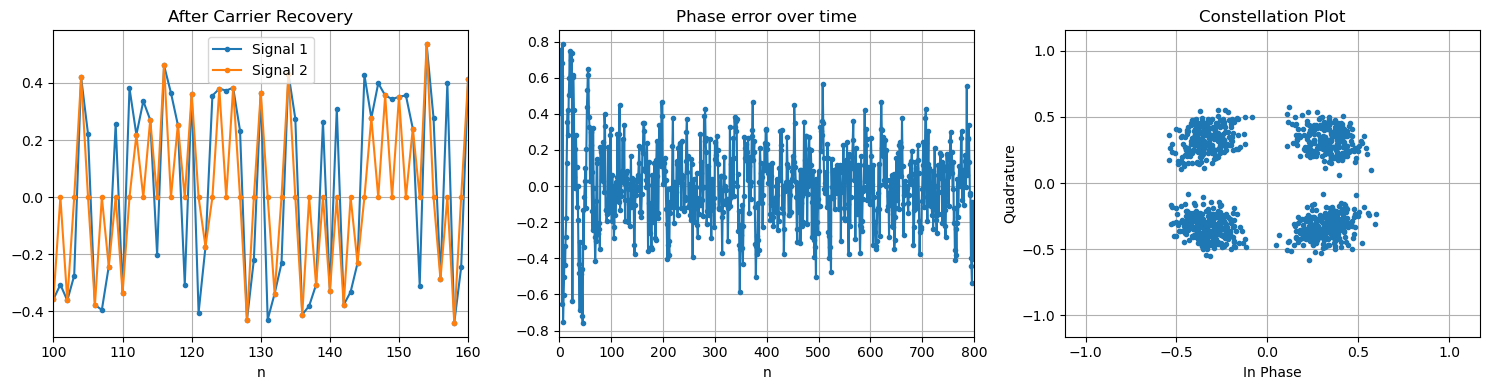

In [10]:
### Symbol Synchronization ###

"""
Gardner: 
- Low complexity
- 2x oversampling fine since sample rate is same for both rx and tx on PlutoSDR
- Better than M&M in lower SNR environments
- Real-time low-latency

cubic interpolation:
- Complexity not bad (better than sinc) when using Farrow structures
- More accurate than lower order quadratic interpolaters
"""

delta_t = 0.0
buf_size = 5
n = np.arange(buf_size)



sig_dec = sig_matched[::SPS]


### Carrier Recovery ###
# 2nd Order Costas Loop
K_p = 0.04
K_i = 0.03

control = PIDFeedback(K_p, K_i)
lock_detector = PhaseLockDetector()
error = np.empty_like(sig_dec)
sym_rot = costas_loop(sig_dec, control, lock_detector, debug=error)
samples = np.array([sym_rot[i]*(i % SPS == 0) for i in np.arange(sym_rot.size)], dtype=sym_rot.dtype)


fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sym_rot.real, samples.real, title='After Carrier Recovery', xlim=[50*SPS, 80*SPS], ax=axs[0])
plot_signal(error, title='Phase error over time', xlim=[0, 800], ax=axs[1])
plot_constellation(sym_rot[1000:], n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()

    

In [11]:
### Demodulation ###

# Make optimum decision for AWGN channel
bits_rx = demodulate_qpsk(diff_decode_psk_symbols(optimum_decider_qpsk(sym_rot)))

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 9.4e-05


In [12]:
print(bits_tx[0:15])
print(bits_rx[0:15])
locs = []
for i in range(len(bits_tx)):
    if bits_tx[i] != bits_rx[i]:
        locs.append(i)

print(np.sum(bits_rx != bits_tx))

[0 1 1 1 1 1 0 1 1 1 1 0 0 1 1]
[0 1 1 1 1 1 0 1 0 1 0 0 0 0 1]
94


0.49987179180437763


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


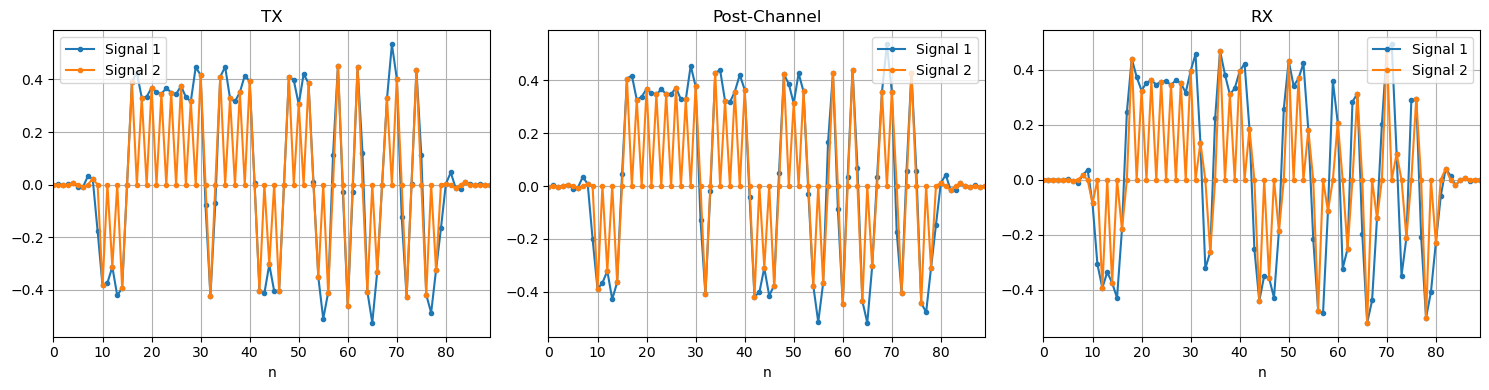

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))


SPS = 2
N_RRC_TAPS = SPS*10 + 1
N_SAMPS = 70

# TX
h_rrc = rrc_coef(Ts=SPS, n_taps=N_RRC_TAPS)
s = np.convolve(upsample(modulate_qpsk(np.random.randint(2, size=N_SAMPS)), SPS), h_rrc)
samples = np.array([s[i]*(i % SPS == 0) for i in np.arange(s.size)], dtype=s.dtype)
plot_signal(s, samples, title="TX", ax=axs[0])


# Channel
mu = 0.1
s = apply_sto(s, mu)

samples = np.array([s[i]*(i % SPS == 0) for i in np.arange(s.size)], dtype=s.dtype)

plot_signal(s, samples, title="Post-Channel", ax=axs[1])


# RX
# s = np.convolve(s, h_rrc)[20:-20]
stc = SymbolTimingCorrector()
s = stc.correct_batch(batch=s)
samples = np.array([s[i]*(i % SPS == 0) for i in np.arange(s.size)], dtype=s.dtype)
plot_signal(s, samples, title="RX", ax=axs[2])
print(stc.mu)

plt.tight_layout()
plt.show()


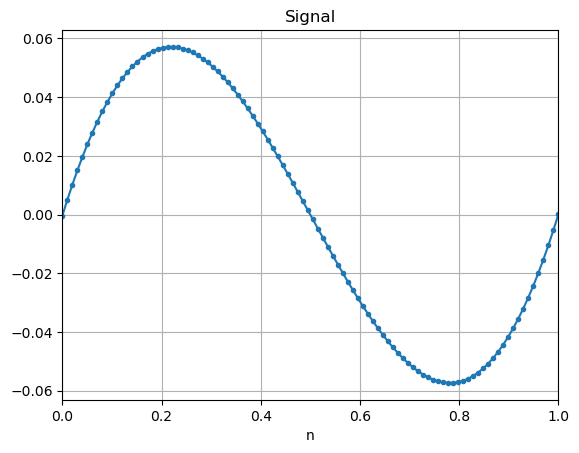

In [33]:
farrow = CubicFarrowInterpolator()

a = farrow.process_batch_with_tail_padding(np.array([0, 1, 2, 3, 4, 5]), .5)
# a = farrow.process_batch(np.array([0, 1, 2, 3, 4, 5]), 0.5)
# print(a.real)



# x = np.linspace(0, 2 * np.pi, 100)  # Generates 100 points between 0 and 2π
# b1 = np.sin(x*20)

b1 = np.array([1, 0, -1, 0] * 40)
b2 = apply_sto(b1, 0.7)
b3 = apply_sto(b2, 0.3, 1)
# plot_signal(b1, b2, b3, n_samps=10)

N_SAMPS=700
s = np.convolve(upsample(modulate_qpsk(np.random.randint(2, size=N_SAMPS)), SPS), h_rrc)
s = upsample(modulate_qpsk(np.random.randint(2, size=N_SAMPS)), SPS)
s = np.array([1, 0, -1, 0] * (N_SAMPS//4))
s = apply_sto(s, 0.7)
# s = np.convolve(s, h_rrc)[20:-20]

# s = apply_sto(s, 0.3)
# plot_signal(s[0:100])

mu = np.linspace(0, 1, 100)
# mean_e = np.zeros(len(s)+1)
all_e = np.empty((0, len(mu)))  # empty array with 0 rows, len(mu) columns


farrow.reset()
for i, samp in enumerate(s):
    farrow.load(samp)
    # all_e = np.append(all_e, [gardner_ted(m, farrow) for m in mu], axis=0)
    # all_e = np.vstack([all_e, [gardner_ted(m, farrow) for m in mu]])
    row = [gardner_ted(m, farrow) for m in mu]
    all_e = np.vstack([all_e, row])  # append row to all_e
    # print(all_e)

mean_e = np.array([])
for i in range(len(mu)):
    mean_e = np.append(mean_e, np.mean(all_e[:, i]))

plot_signal(mean_e, x=mu)


# s = np.convolve(apply_sto(s, 0.7), h_rrc)[n:(n+15)]
# plot_signal(s)
# farrow.load(s)
# print(f"buffer {list(farrow.buffer)}")

# mu = np.linspace(0, 1, 100)
# e = np.array([gardner_ted(m, farrow) for m in mu])
# plot_signal(e, x=mu)



# help(np.arange)

In [ ]:
a = np.array([])
a = np.append(a, 1)
a